In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from downsampling import bicubic_interpolation
from einops.layers.torch import Rearrange
from scipy.signal import correlate2d
from preprocessing import downsample_MTF

In [16]:
divisers=[1000,1900,3000,3300,3800,3900,4400,4500,5900,5900]
min,max=[10000,10000,10000,10000,10000,10000,10000,10000,10000,10000],[0,0,0,0,0,0,0,0,0,0]
mean,std=[0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0,0,0]
mean_context,std_context=[0,0],[0,0]
referance_data=rasterio.open("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp0/referenceallproperty_0/allproperty_0.tif")
referance=referance_data.read().astype(np.int16)#referance image for differance
cumimage=np.zeros_like(referance)#cumilative image
referance_context=torch.load("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp0/referenceallproperty_0/context.pt")#referance for context
cumcontext=torch.zeros_like(referance_context)
normalized_refrance=np.zeros((10,12,21))
for i in range(10):
    normalized_refrance[i]=downsample_MTF(referance[i],0.15).astype(np.float32)
normalized_refrance_tensor=torch.tensor(normalized_refrance)


In [17]:
datasize=len(os.listdir('C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2'))
for dir in os.listdir('C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2'):
    dataset=rasterio.open(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir,(os.listdir(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir))[0])))
    image=dataset.read().astype(np.float32)
    m=np.max(image,axis=(1,2))
    mi=np.min(image,axis=(1,2))
    for i in range(10):
        max[i]=m[i] if m[i]>max[i] else m[i]#calculating Max
        min[i]=mi[i] if mi[i]<min[i] else mi[i]#calculating Min 
    cumimage=cumimage+referance-image#calculating cumalitave image
    context=torch.load(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir,(os.listdir(os.path.join("C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2",dir))[1])))
    cumcontext=cumcontext+context-referance_context
cumimage=np.reshape(cumimage,(10,-1))
print(np.shape(cumimage))
mean=np.mean(cumimage[:,abs(cumimage[0,:])>0.01],axis=1)/datasize #calculating the mean for pixels that are not purely Soil
median=np.median(cumimage,axis=1)/datasize #calculating median
std=np.std(cumimage[:,abs(cumimage[0,:])>0.01],axis=1)/datasize #calculating the mean for pixels that are not purely Soil
mean_context=torch.mean(cumcontext,(1,2))/datasize
std_context=torch.std(cumcontext,(1,2))/datasize
print(mean,std,median,mean_context,max,min)

(10, 3936)
[ -62.91824  -152.21434  -230.8547   -271.3486   -149.08957   -24.496984
  -34.24914   -36.191723 -408.5989   -457.48602 ] [ 79.71927 172.35207 285.2278  311.16858 231.39432 246.32309 256.7084
 258.08432 529.57556 569.7717 ] [ 0.0000000e+00 -7.1763732e-03 -4.8302510e-03 -3.3535745e-02
  1.6645045e+00  4.9595637e+00  5.3089981e+00  5.4195418e+00
  1.5474745e+00  0.0000000e+00] tensor([-3.0140e+00, -6.8243e-04]) [739.0, 1497.0, 2385.0, 2676.0, 3418.0, 3943.0, 4045.0, 4055.0, 5085.0, 4827.0] [104.0, 199.0, 131.0, 319.0, 998.0, 1276.0, 1332.0, 1339.0, 798.0, 256.0]


In [18]:
#Transformation 
transforms = v2.Compose([v2.Normalize(mean, std),v2.ToDtype(torch.float32)])
transforms_context=None#v2.Compose([])

# CustomDataset
A customdataset class to navigate the image folder  

In [19]:
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform=None,transforms_context=None):
        self.img_dir = img_dir
        self.transform = transform
        self.transforms_context = transforms_context
    def __len__(self):
        return len(os.listdir(self.img_dir))
        
    def __getitem__(self,idx):
        img_path = os.path.join(self.img_dir,os.listdir(self.img_dir)[idx])
        context_path = os.path.join(img_path,os.listdir(img_path)[1])
        img_path=os.path.join(img_path,os.listdir(img_path)[0])
        dataset=rasterio.open(img_path)
        image=dataset.read()
        tensr=(np.zeros((10,12,21)))
        for i in range(10):
            tensr[i]=downsample_MTF(image[i],0.15).astype(np.int16)
        tensr=torch.tensor(tensr)
        patch=torch.load(context_path)
        #np.reshape((normalized_refrance_tensor-tensr)[0],15*27)
        #plt.hist(np.reshape((normalized_refrance_tensor-tensr)[0],15*27),bins=100)
        #a=np.median((normalized_refrance_tensor-tensr)[0])
        #plt.show()
        if self.transform:    
            tensr = self.transform(normalized_refrance_tensor-tensr)
        if self.transforms_context:
            patch=self.transforms_context(patch)
        #plt.hist(torch.reshape(tensr[0],(15*27,)),bins=100)
        #plt.show()
        #print(a,torch.median(tensr))
        output=torch.zeros(10,12,24)
        output[0:10,0:12,0:21]=tensr
        #for i in range(10):
        #    output[i]=torch.div(output[i],max[i]-min[i])
        return (output,patch)

# Initialization
intializing variables

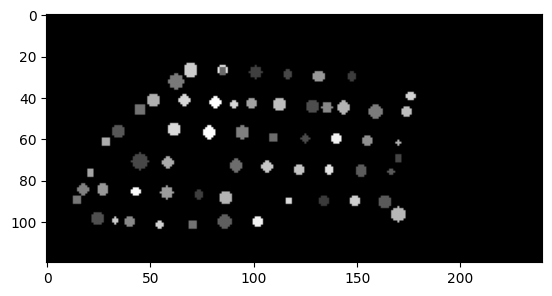

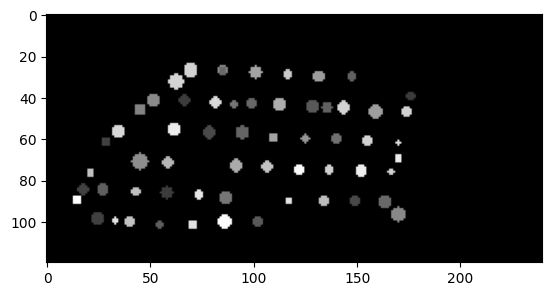

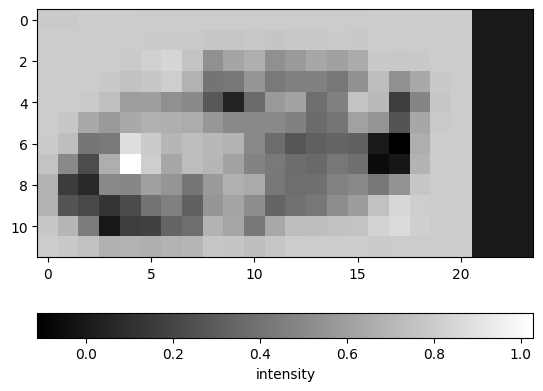

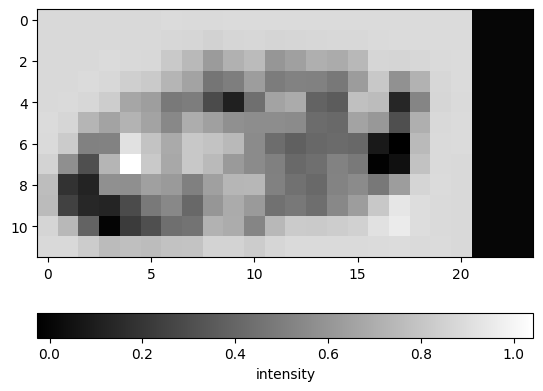

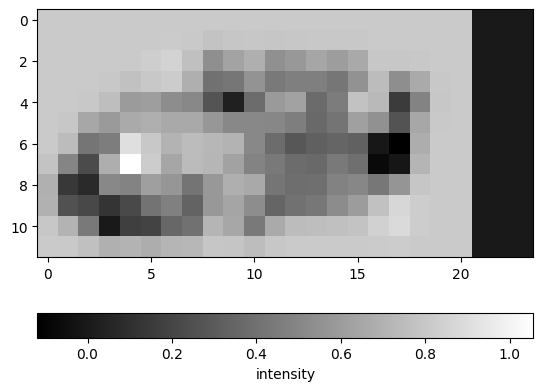

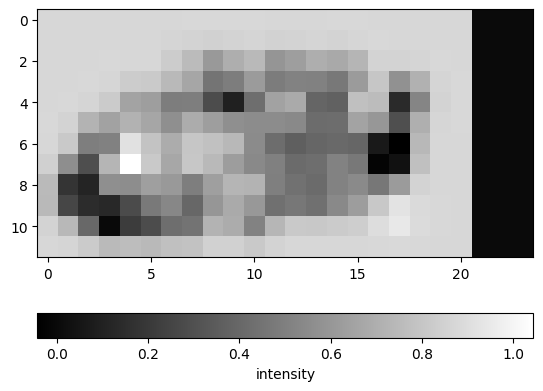

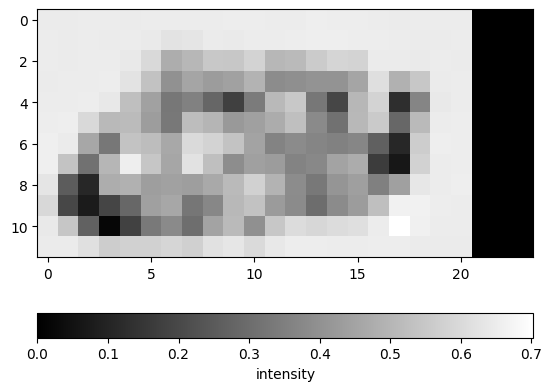

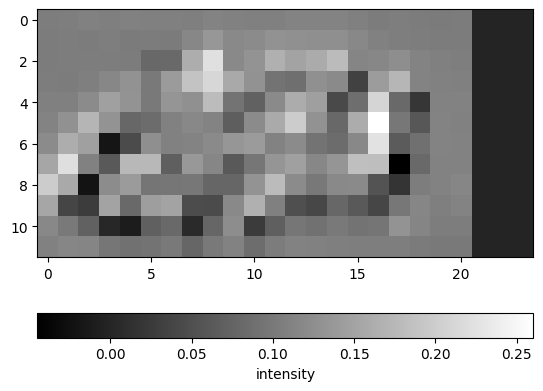

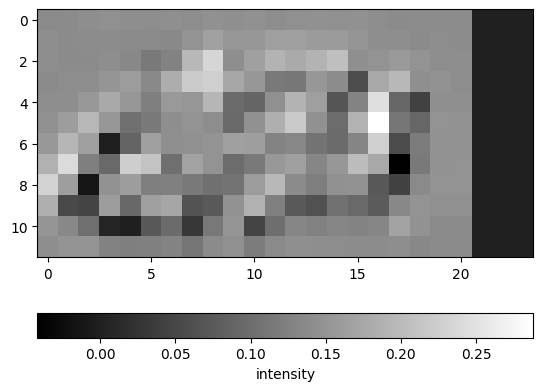

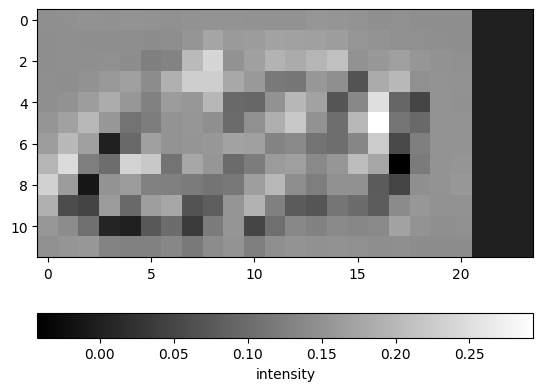

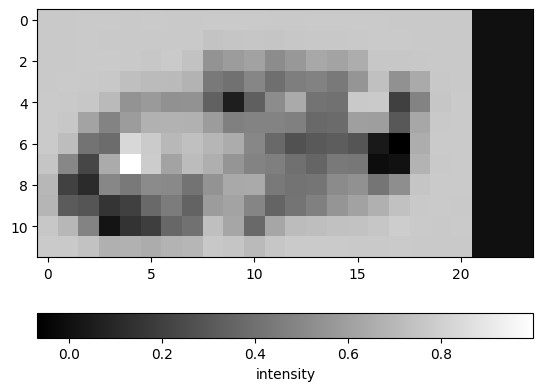

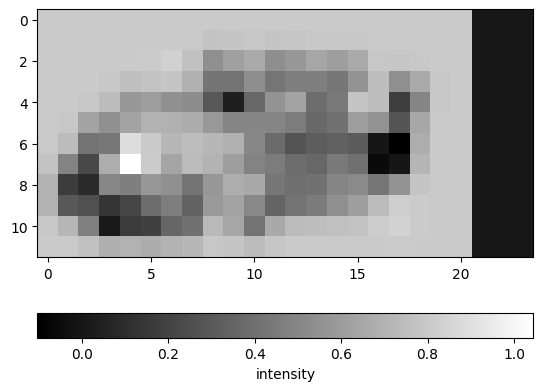

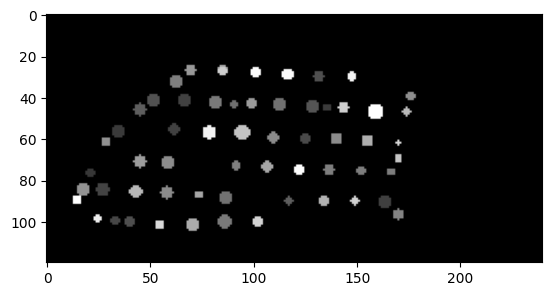

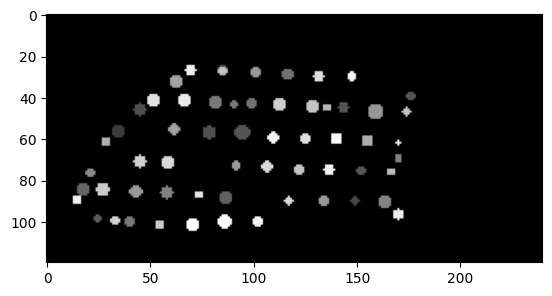

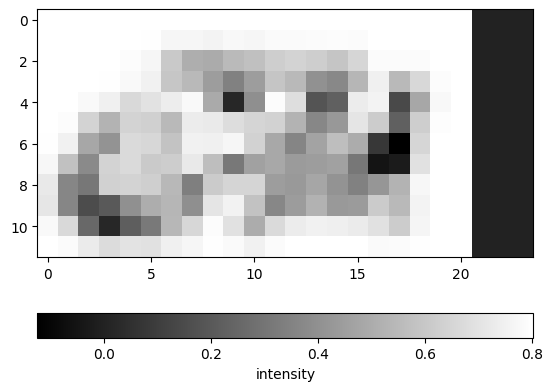

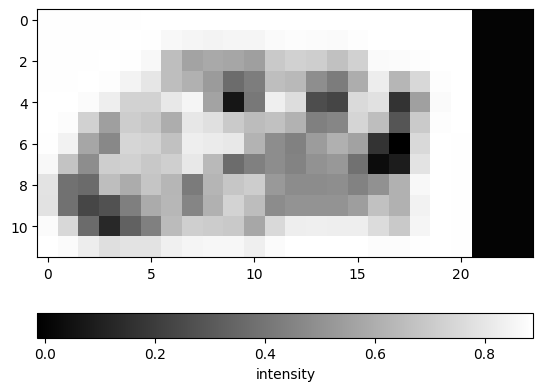

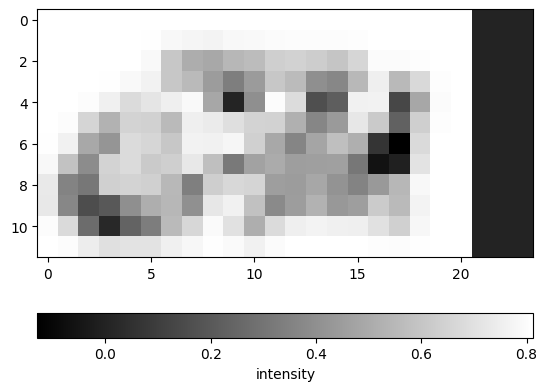

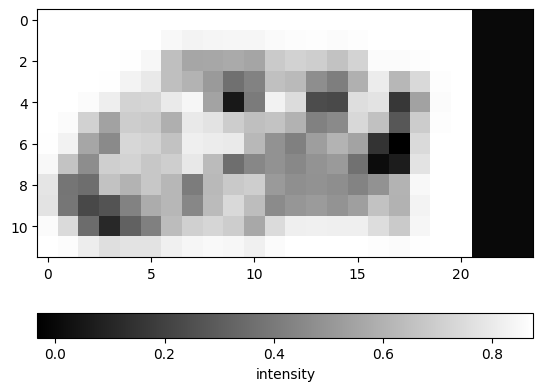

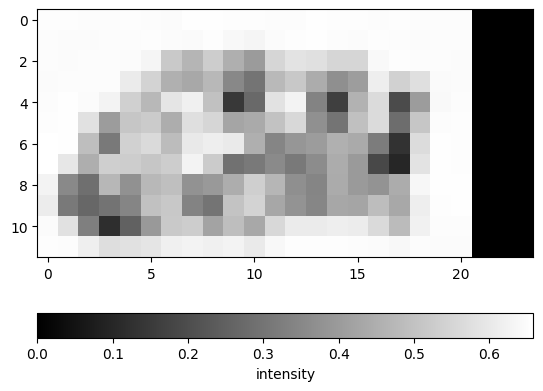

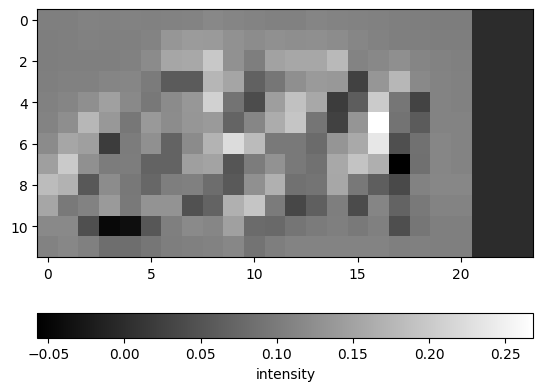

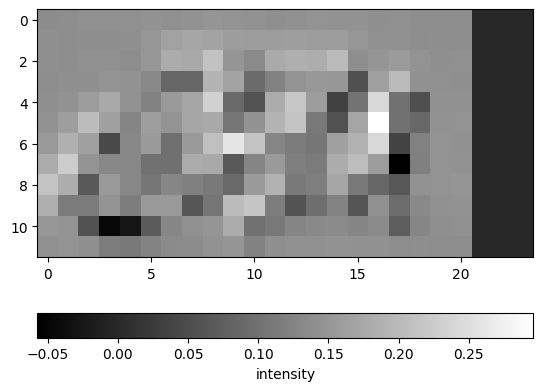

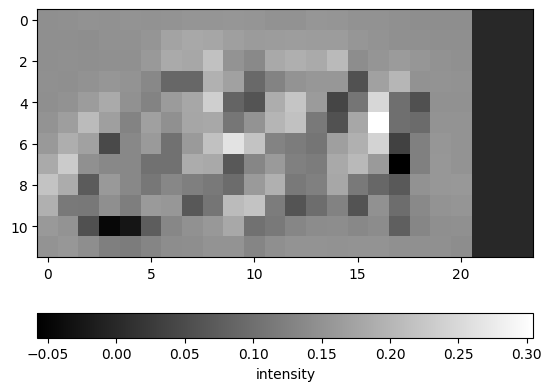

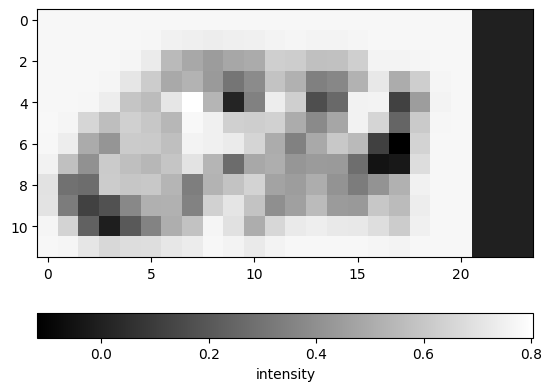

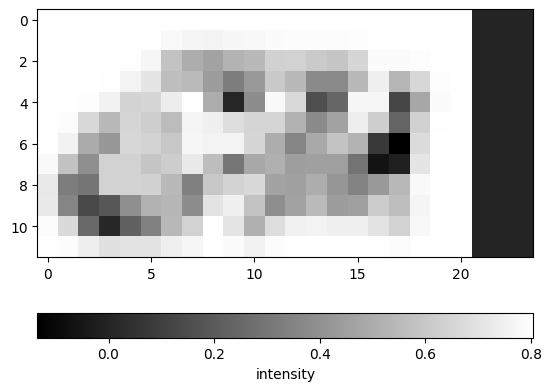

In [20]:
img_dir="C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp2/"
IMG_height,IMG_width = 12,24
IMG_CH = 10
BATCH_SIZE = 100
data = CustomDataset(img_dir,transforms,transforms_context)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d=(data[0],data[1])

for i,k in d:
    h=k
    plt.imshow(k[1],cmap='gray')
    plt.show()
    plt.imshow(k[0],cmap='gray')
    plt.show()
    for j in range(10):
        plt.imshow((i[j]),cmap='gray')
        plt.colorbar(label="intensity", orientation="horizontal") 
        plt.show()


# Initializing noising variables

In [21]:
nrows = 20
ncols = 25

T = nrows * ncols
start = 0.0001
end = 0.02*2
B = torch.linspace(start, end, T).to(device)
a = 1. - B
a_bar = torch.cumprod(a, dim=0)
sqrt_a_bar = torch.sqrt(a_bar)  # Mean Coefficient
sqrt_one_minus_a_bar = torch.sqrt(1 - a_bar) # St. Dev. Coefficient

# Time independant noise function

In [22]:
def q(x_0, t):
    """
    Samples a new image from q
    Returns the noise applied to an image at timestep t
    x_0: the original image
    t: timestep
    """
    t = t.int()
    noise = torch.randn_like(x_0)
    sqrt_a_bar_t = sqrt_a_bar[t, None, None, None]
    sqrt_one_minus_a_bar_t = sqrt_one_minus_a_bar[t, None, None, None]
    x_t = sqrt_a_bar_t * x_0 + sqrt_one_minus_a_bar_t * noise
    return x_t, noise

In [23]:
""""#plt.figure(figsize=(28, 28))
x_0 = data[0][0][0].to(device)  # Initial image
x_t = x_0
#xs = []
y,z=[],[]
for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, _ = q(x_0, t_tenser)
    #img = torch.squeeze(x_t).cpu()
    #xs.append(img)
    #ax = plt.subplot(40, 50, t + 1)
    #ax.axis('off')
    #plt.imshow(img)
    if t % 25 == 0:
        x=x_t[0][0].cpu().numpy()
        print(np.shape(x))
        z.append(t)
        y.append(np.mean(correlate2d(x,x)[16,26]))       
#plt.savefig("forward_diffusion_skip.png", bbox_inches='tight')"""

'"#plt.figure(figsize=(28, 28))\nx_0 = data[0][0][0].to(device)  # Initial image\nx_t = x_0\n#xs = []\ny,z=[],[]\nfor t in range(T):\n    t_tenser = torch.Tensor([t]).type(torch.int64)\n    x_t, _ = q(x_0, t_tenser)\n    #img = torch.squeeze(x_t).cpu()\n    #xs.append(img)\n    #ax = plt.subplot(40, 50, t + 1)\n    #ax.axis(\'off\')\n    #plt.imshow(img)\n    if t % 25 == 0:\n        x=x_t[0][0].cpu().numpy()\n        print(np.shape(x))\n        z.append(t)\n        y.append(np.mean(correlate2d(x,x)[16,26]))       \n#plt.savefig("forward_diffusion_skip.png", bbox_inches=\'tight\')'

In [24]:
"""plt.title("cross-correlation")
plt.xlabel("step")
plt.ylabel("correlation")

plt.plot(z,y)
plt.show()"""

'plt.title("cross-correlation")\nplt.xlabel("step")\nplt.ylabel("correlation")\n\nplt.plot(z,y)\nplt.show()'

In [25]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [26]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [27]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [28]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [29]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x,skip),1)
        x = self.model(x)
        return x

In [30]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [31]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [41]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (160, 160, 320)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_height = IMG_height // 4 # 2 ** (len(down_chs) - 1)
        latent_image_width = IMG_width // 4
        t_dim = 8
        group_size_base = 5
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        
        #context formatting
        #reducing image size from 2*120*240 to 10*12*24
        self.format0=nn.Sequential(
            nn.Conv2d(2,10, 3, 1, 1),
            nn.BatchNorm2d(10),
            nn.GELU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10,20, 3, 1, 1),
            nn.BatchNorm2d(20),
            nn.GELU(),
            nn.Conv2d(20,40, 3, 1, 1),
            nn.BatchNorm2d(40),
            nn.GELU(),
            nn.MaxPool2d(5),
        )
        #reducing image size for upblock2
        self.format1=nn.Sequential(
            #increasing channels 
            GELUConvBlock(40, down_chs[-2], 2),
            GELUConvBlock(down_chs[-2], down_chs[-2], 2),
            #reducing size
            RearrangePoolBlock(down_chs[-2], 2)
        )
        #reducing image size for upblock1
        self.format2=nn.Sequential(
            GELUConvBlock(down_chs[-2], down_chs[-1], 2),
            GELUConvBlock(down_chs[-1], down_chs[-1], 2),
            RearrangePoolBlock(down_chs[-1], 2)
        )
        
        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_height*latent_image_width,down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_height*latent_image_width),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_height, latent_image_width)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t,y):
        format0 = self.format0(y)
        format1 = self.format1(format0)
        format2 = self.format2(format1)
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0*format2+temb_1, down2)
        up2 = self.up2(up1*format1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1))

In [42]:
model = UNet().to(device)

In [34]:
def get_loss(model, x_0, t,y):
    x_noisy, noise = q(x_0, t)
    noise_pred = model(x_noisy,t,y)
    return F.mse_loss(noise, noise_pred)

In [35]:
sqrt_a_inv = torch.sqrt(1 / a)
pred_noise_coeff = (1 - a) / torch.sqrt(1 - a_bar)

In [36]:
@torch.no_grad()
def reverse_q(x_t, t, e_t):
    t = torch.squeeze(t[0].int())  # All t values should be the same
    pred_noise_coeff_t = pred_noise_coeff[t]
    sqrt_a_inv_t = sqrt_a_inv[t]
    u_t = sqrt_a_inv_t * (x_t - pred_noise_coeff_t * e_t)
    if t == 0:
        return u_t  # Reverse diffusion complete!
    else:
        B_t = B[t-1]
        new_noise = torch.randn_like(x_t)
        return u_t + torch.sqrt(B_t) * new_noise

In [37]:
@torch.no_grad()
def sample_images(y,ncols,filename, figsize=(100,100)):
    plt.figure(figsize=figsize)
    plt.axis("off")
    hidden_rows = T / ncols

    # Noise to generate images from
    x_t = torch.randn((1, IMG_CH, IMG_height, IMG_width), device=device)
    # Go from T to 0 removing and adding noise until t = 0
    plot_number = 1
    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device)
        e_t = model(x_t, t,y)  # Predicted noise
        
        x_t = reverse_q(x_t, t, e_t)
        if i % (2*hidden_rows) == 0:
            for j in range(10):
                ax = plt.subplot( ncols ,10, plot_number)
                ax.axis('off')
                plt.imshow(x_t[0][j].squeeze().detach().cpu(),cmap='gray')
                plot_number += 1
    plt.savefig(filename)
    plt.show()


In [38]:
optimizer = Adam(model.parameters(), lr=0.0008)
epochs = 300
ncols = 15  # Should evenly divide T
best=1
model.train()
e=0
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()
        t = torch.randint(0, T, (BATCH_SIZE,), device=device)
        x,y=batch
        x=x.to(device)
        y=y.to(device)
        loss = get_loss(model, x, t,y)
        loss.backward()
        optimizer.step()
    #early stopping method
    if loss.item() > best and e >= 30:
        print(epoch)
        break
    elif loss.item() < best and e<30:
        best=loss.item()
        e=0
    else:
        e+=1
    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Step {step:03d} | Loss: {loss.item()} ")
        #sample_images(y[:1,:,:,:],ncols,'sample' + str(epoch) + '.png')
print("Final sample:",loss.item())
#sample_images(y[:1,:,:,:],ncols,'final_sample.png')
print("best loss:", best)

torch.Size([100, 320, 3, 6]) torch.Size([100, 320, 3, 6])
torch.Size([100, 160, 6, 12]) torch.Size([100, 160, 6, 12])
torch.Size([100, 320, 3, 6]) torch.Size([100, 320, 3, 6])
torch.Size([100, 160, 6, 12]) torch.Size([100, 160, 6, 12])
torch.Size([100, 320, 3, 6]) torch.Size([100, 320, 3, 6])
torch.Size([100, 160, 6, 12]) torch.Size([100, 160, 6, 12])



KeyboardInterrupt



In [ ]:
torch.save(model,"C:/Users/moham/OneDrive/Bureau/summer_internship/model/model.pt")

## Testing
this code cell below shows the difference between original image and genrated image with context

torch.Size([10, 12, 24])
tensor(0.0027, device='cuda:0')


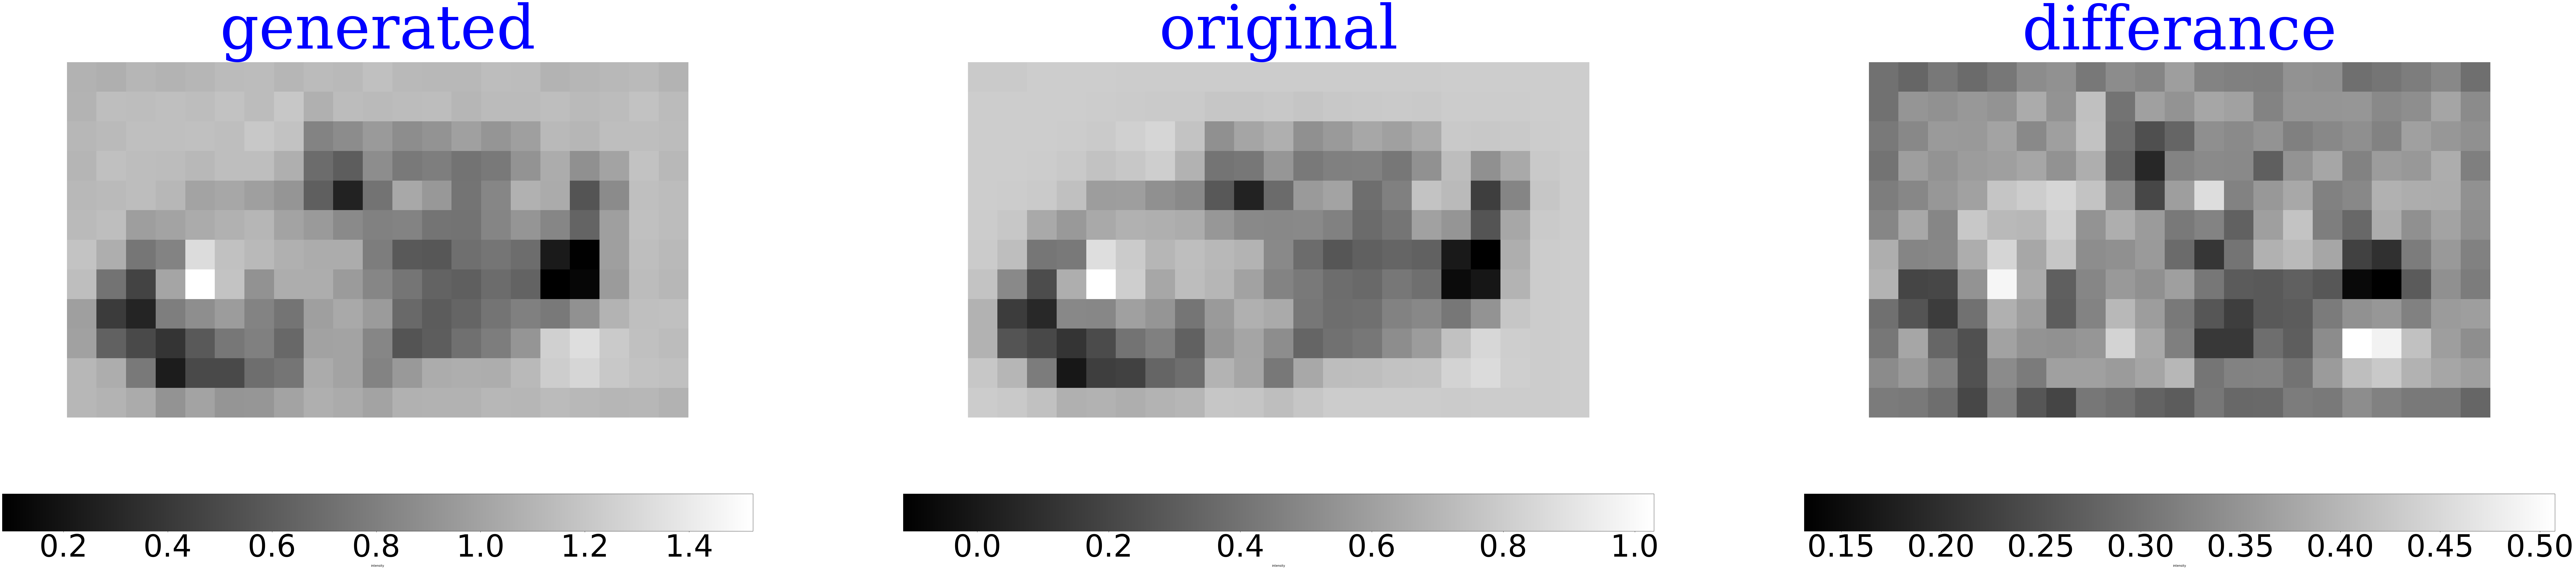

tensor(0.0066, device='cuda:0')


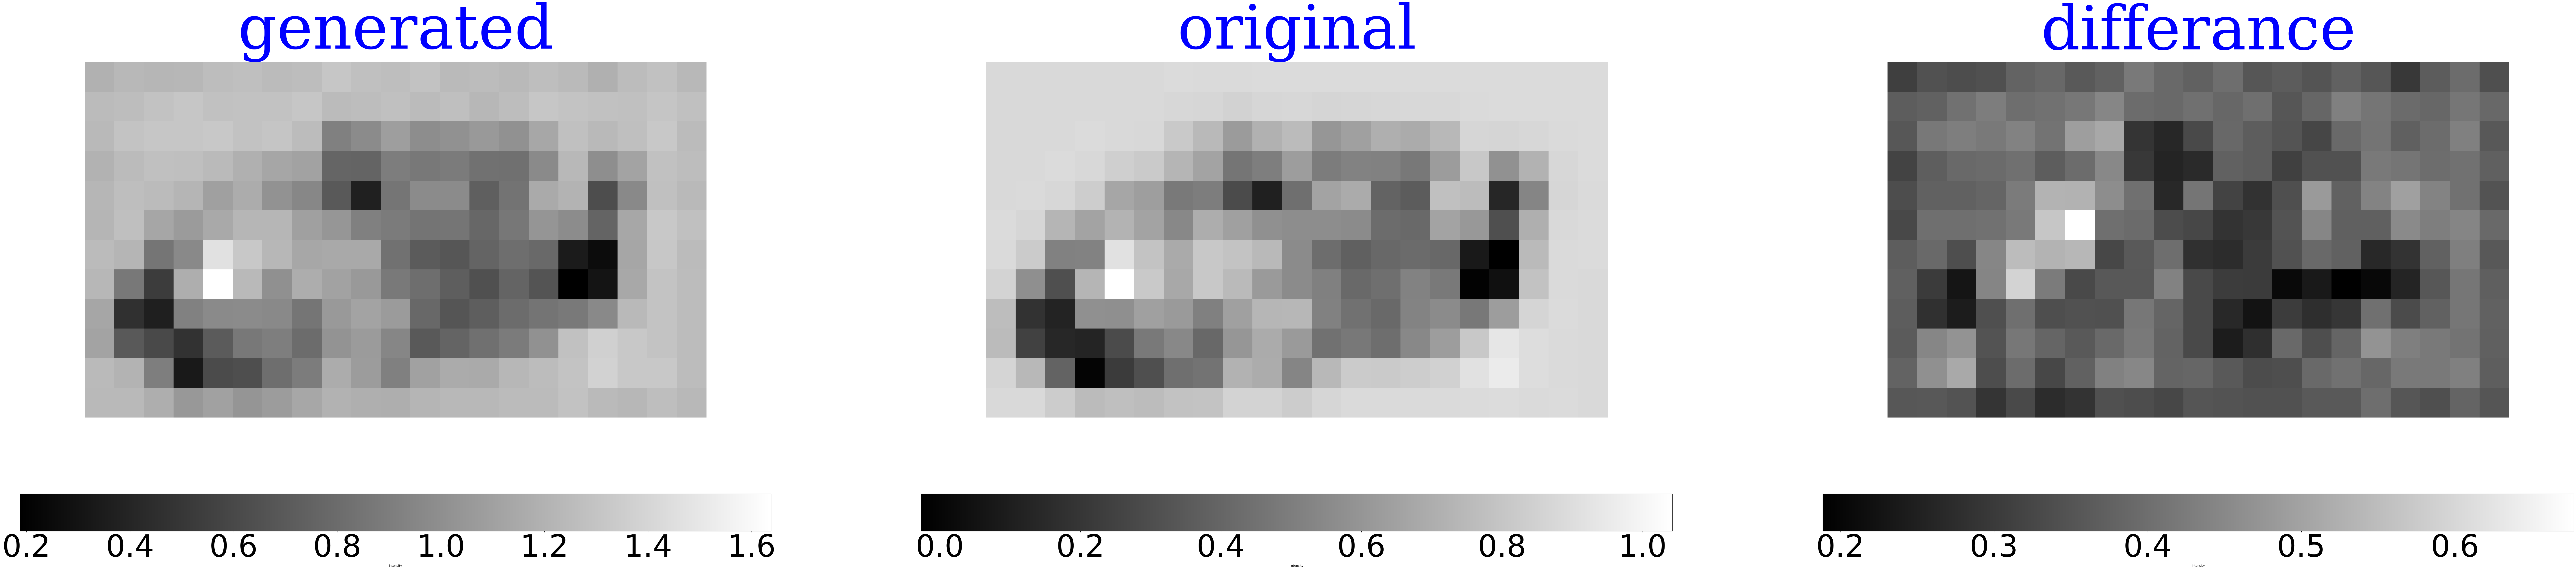

tensor(0.0107, device='cuda:0')


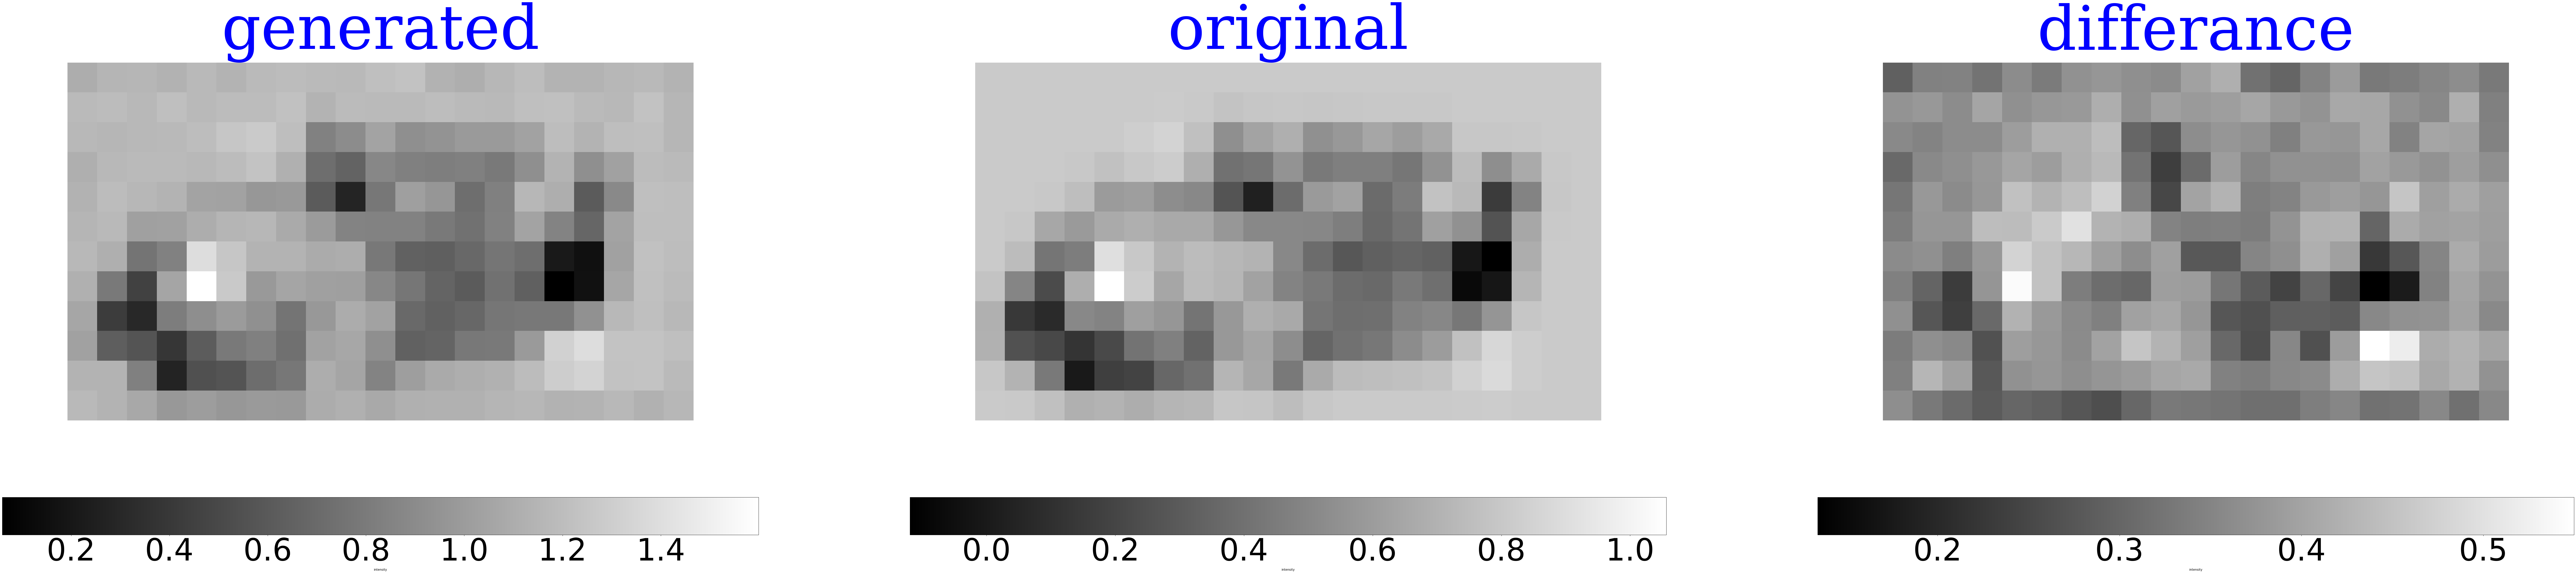

tensor(0.0112, device='cuda:0')


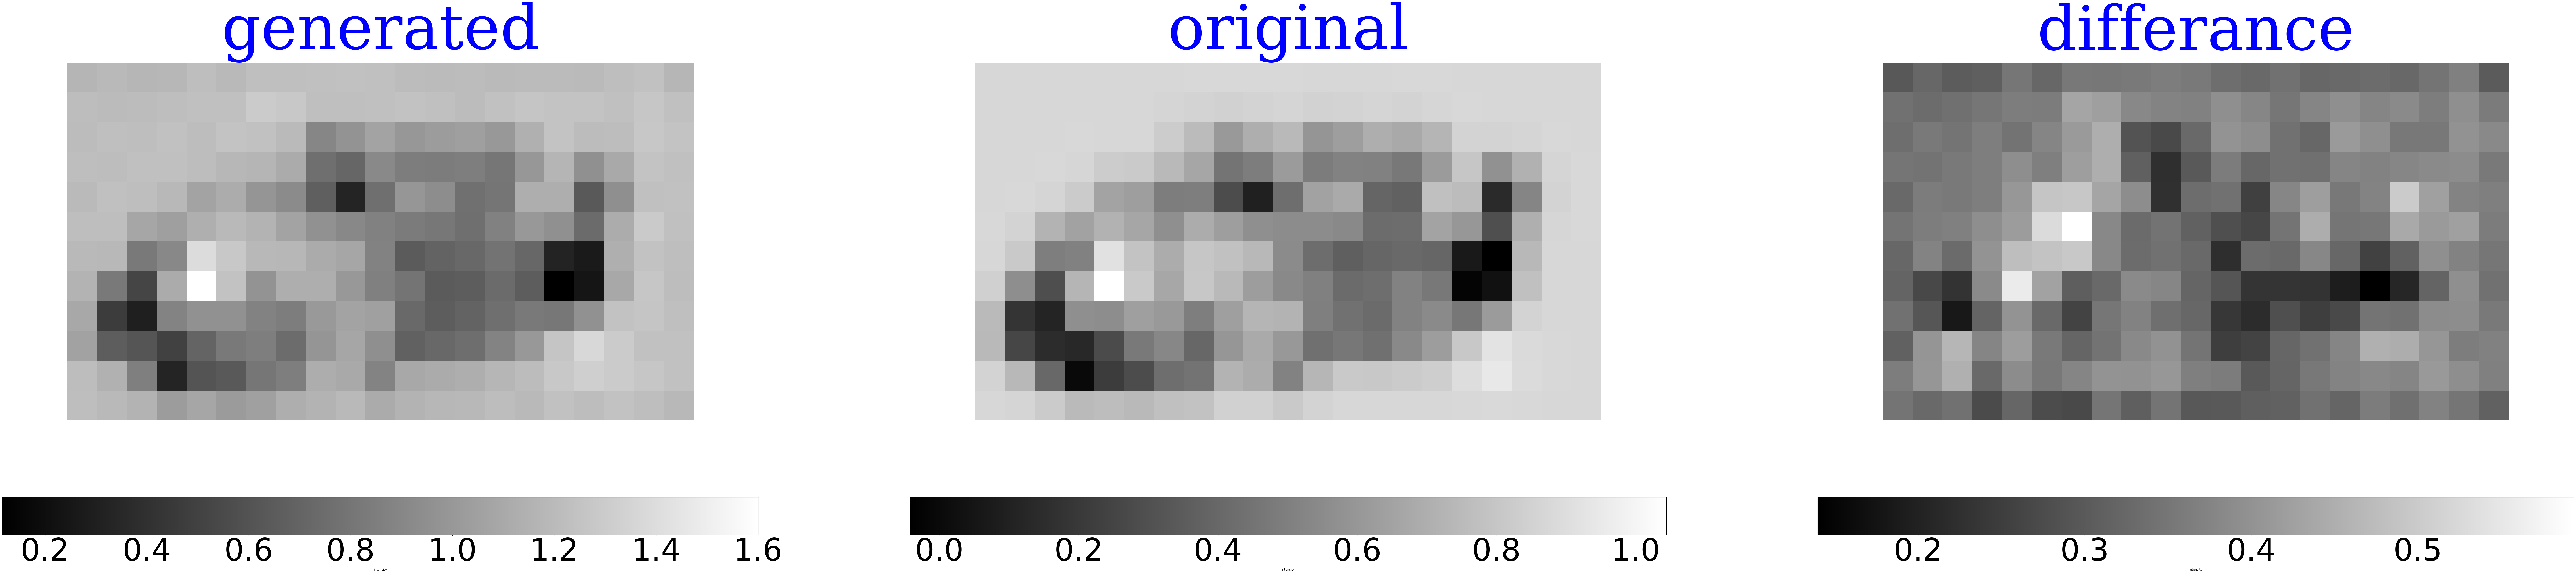

tensor(0.0059, device='cuda:0')


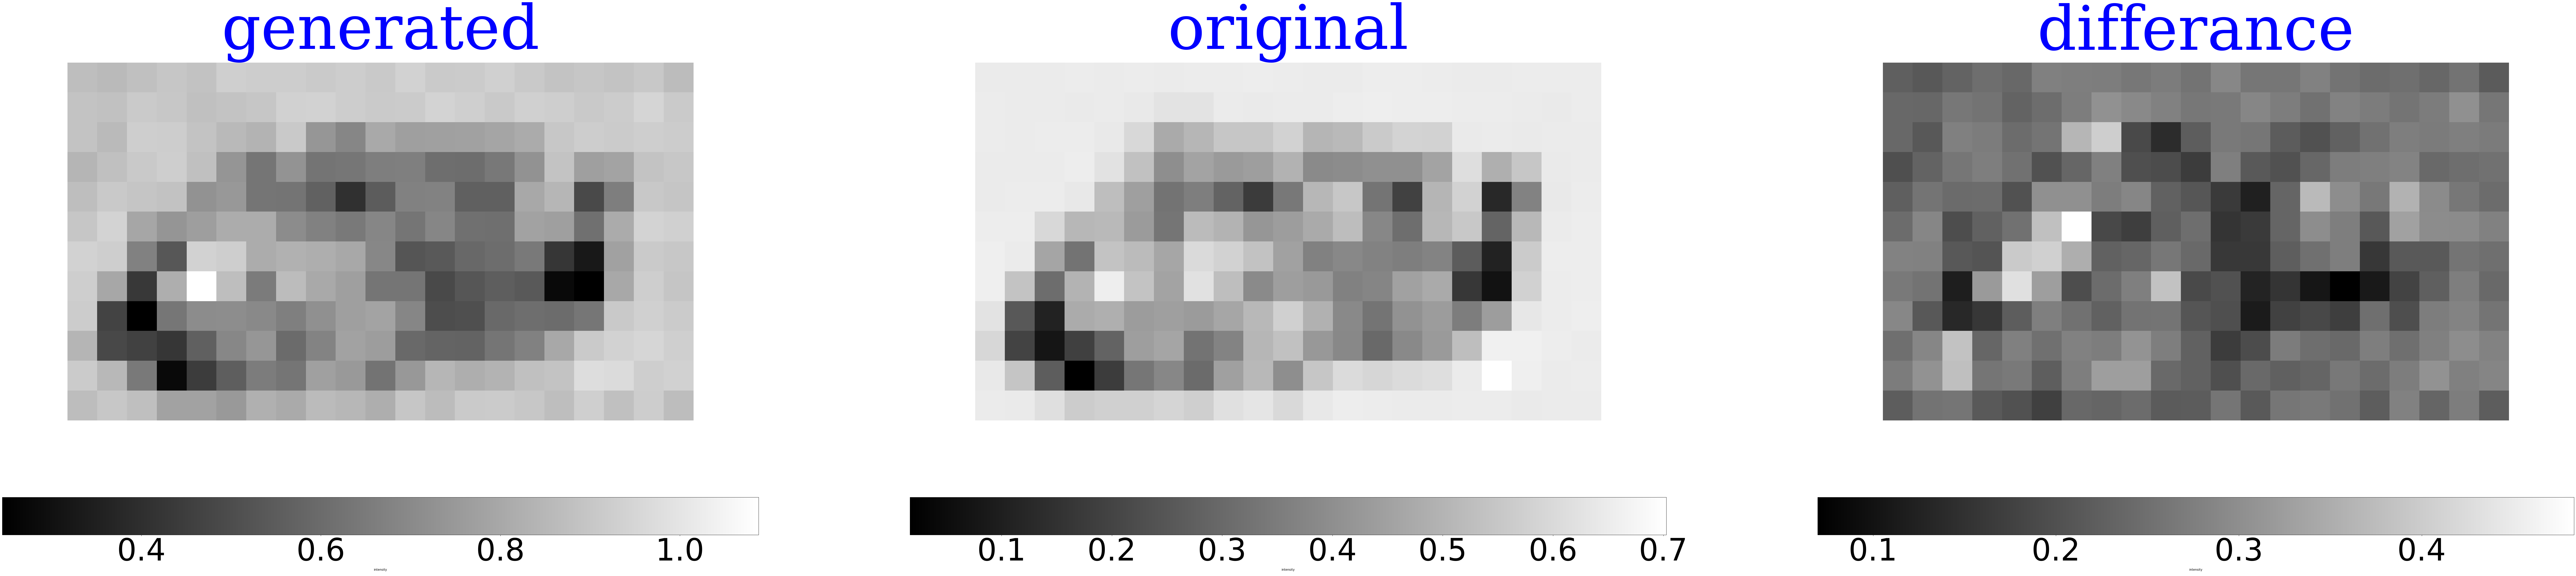

tensor(0.0011, device='cuda:0')


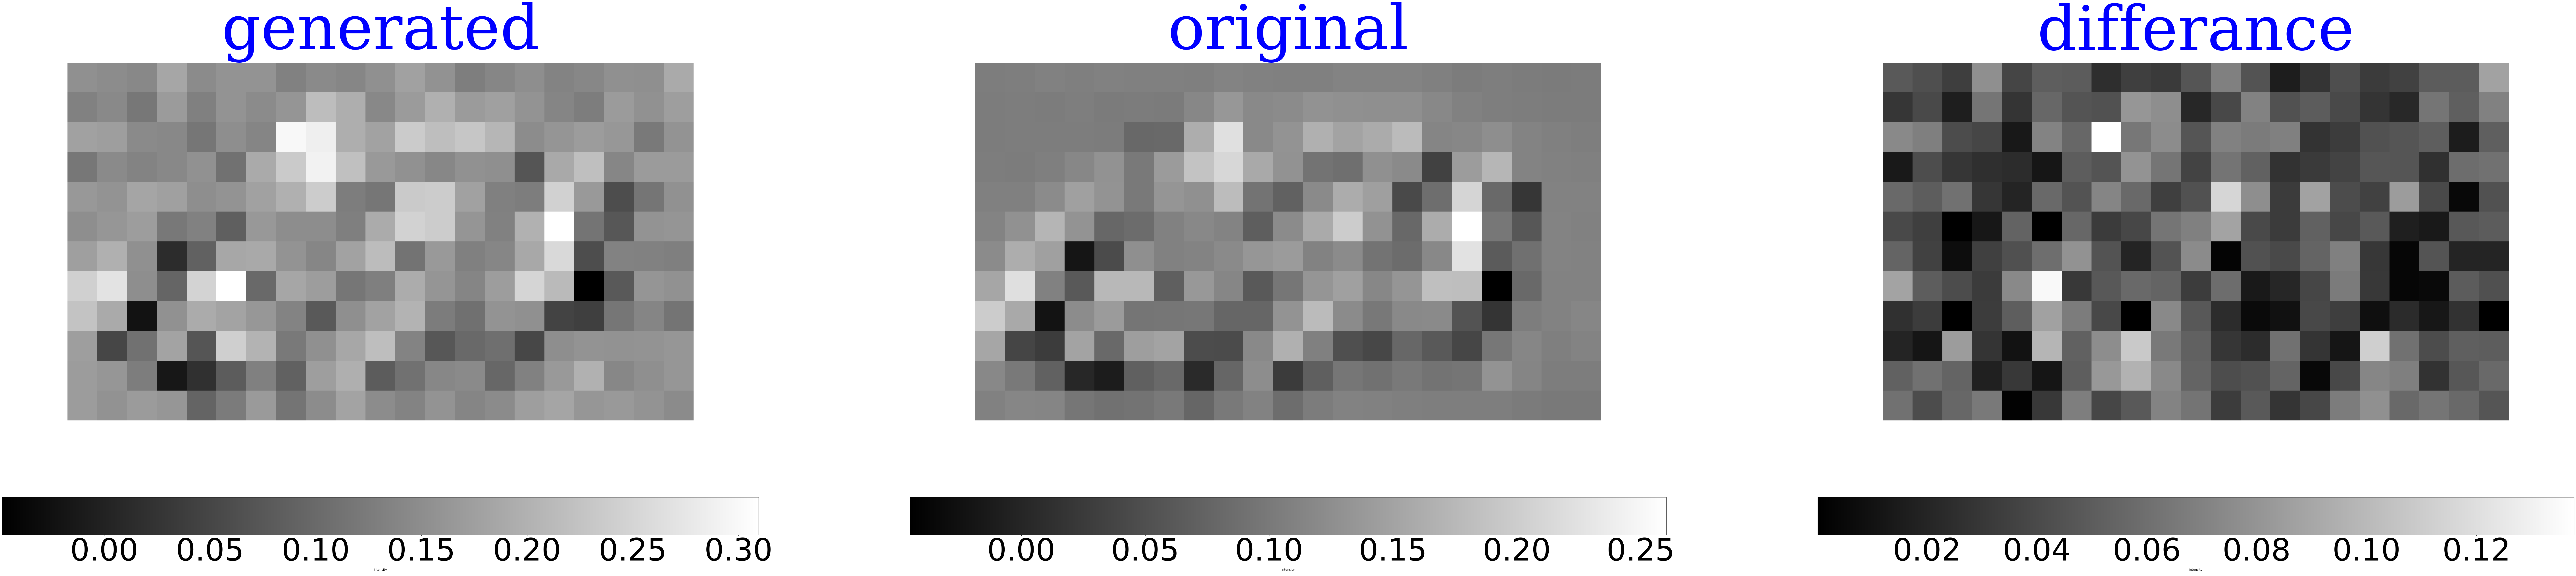

tensor(0.0016, device='cuda:0')


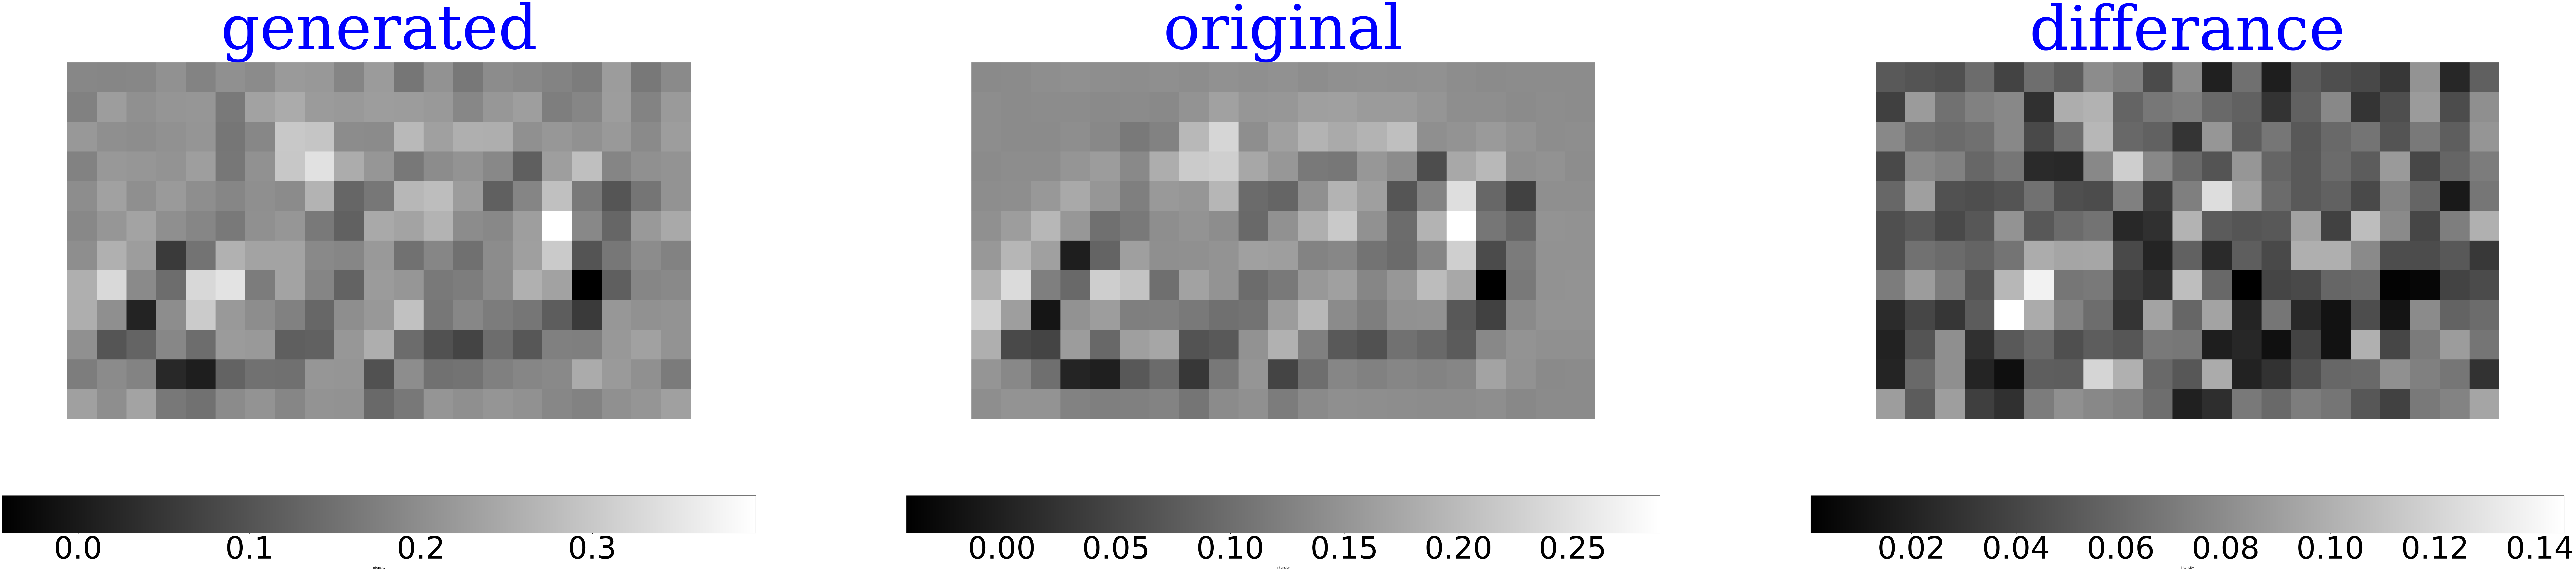

tensor(0.0018, device='cuda:0')


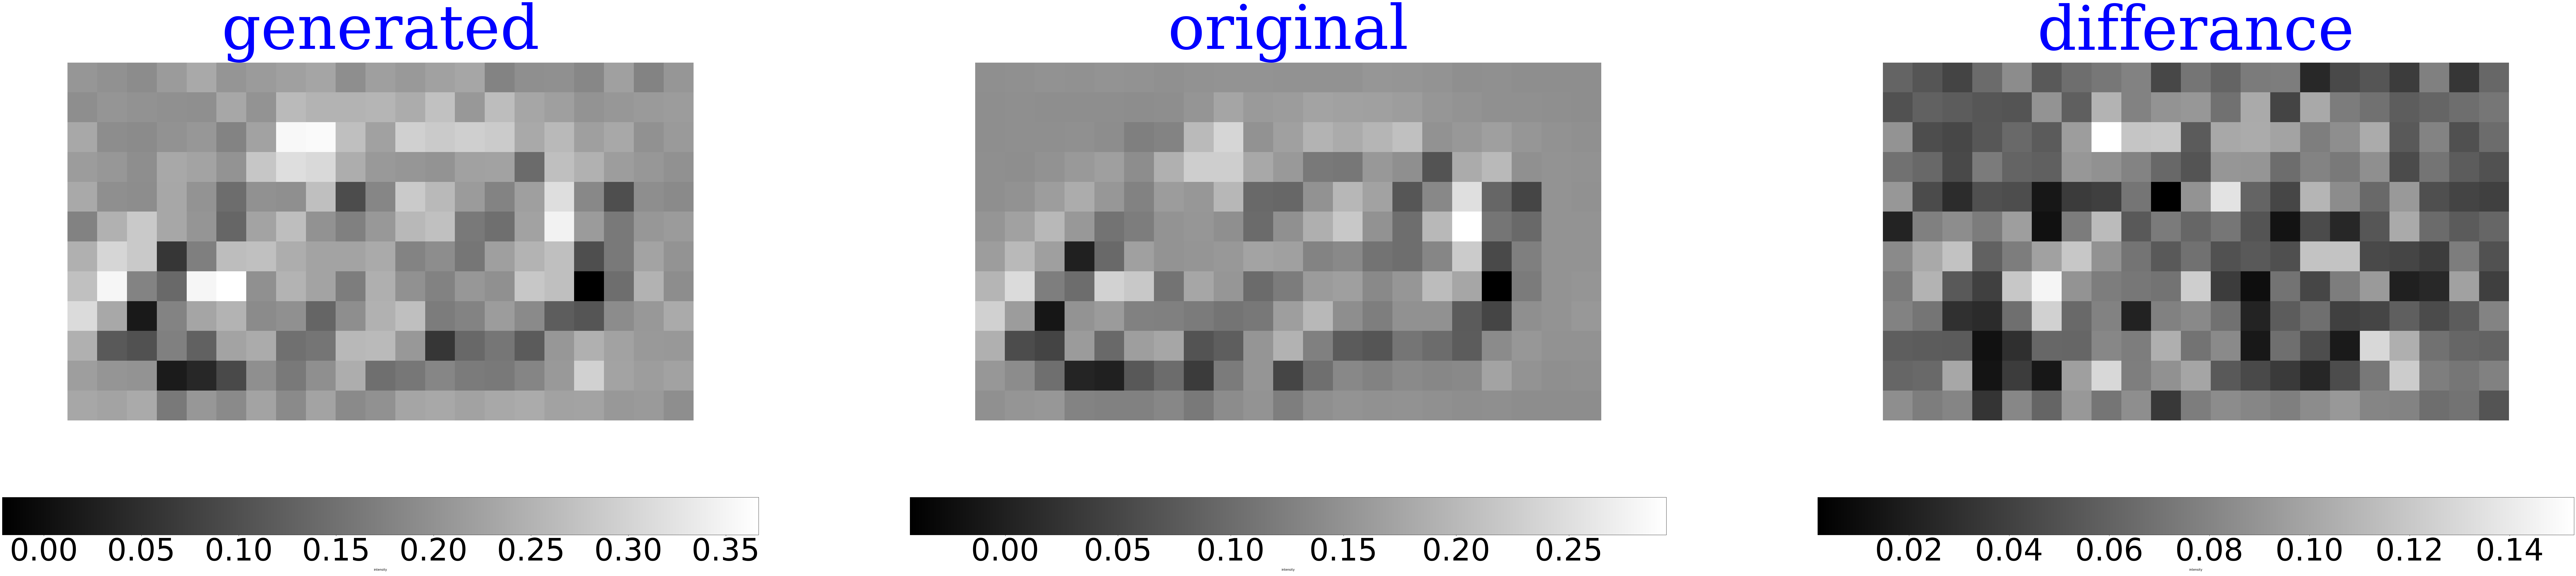

tensor(0.0189, device='cuda:0')


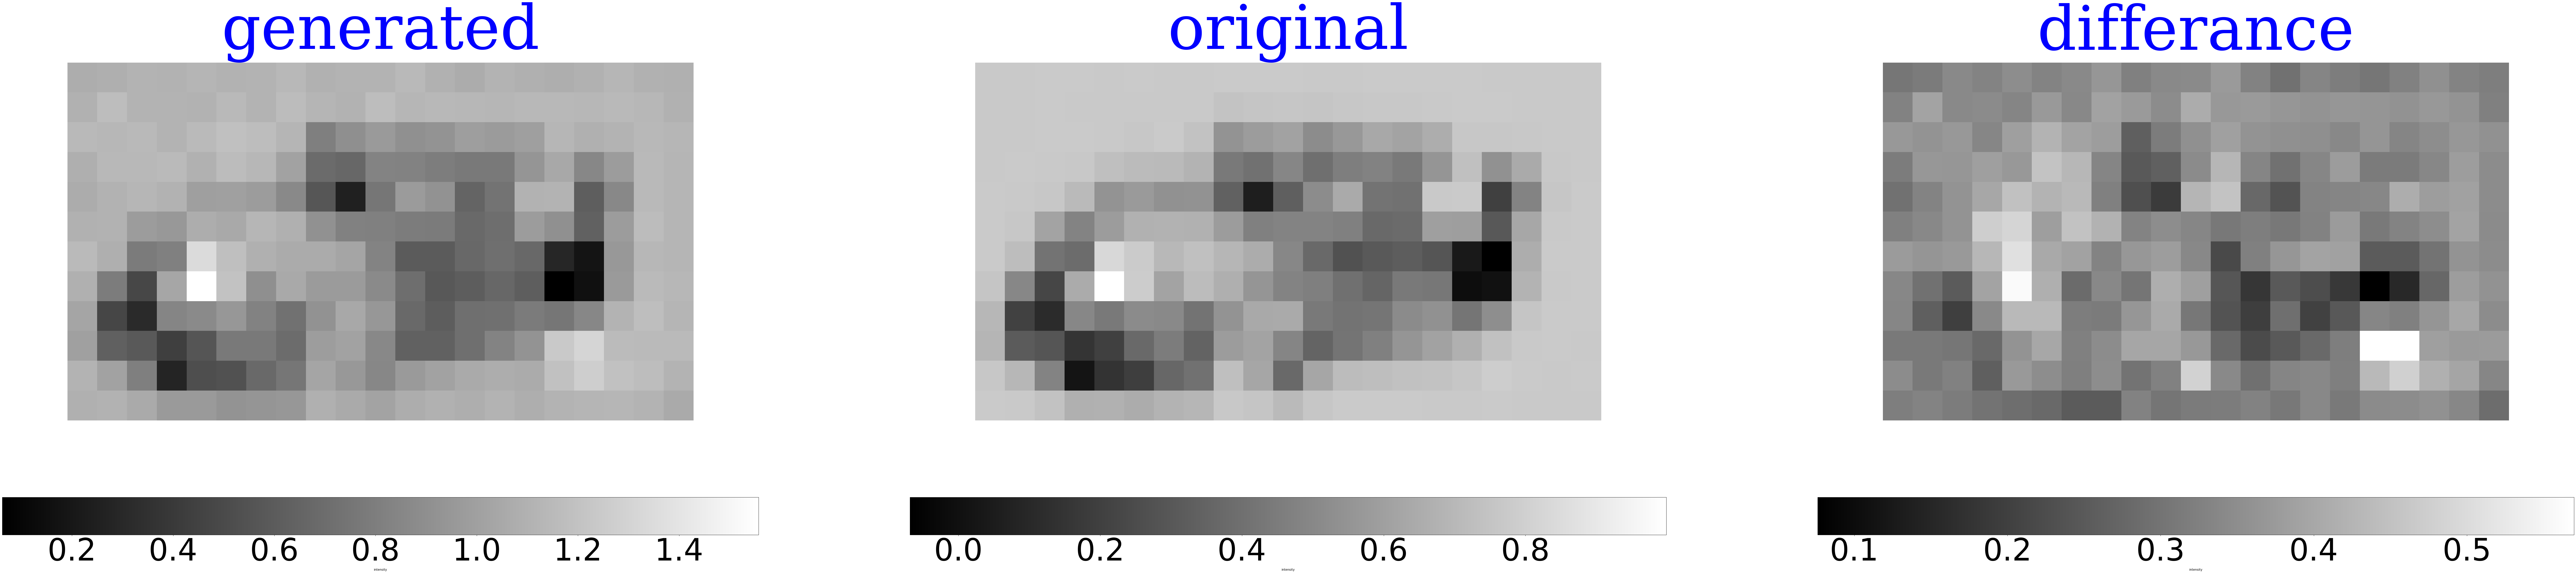

tensor(0.0206, device='cuda:0')


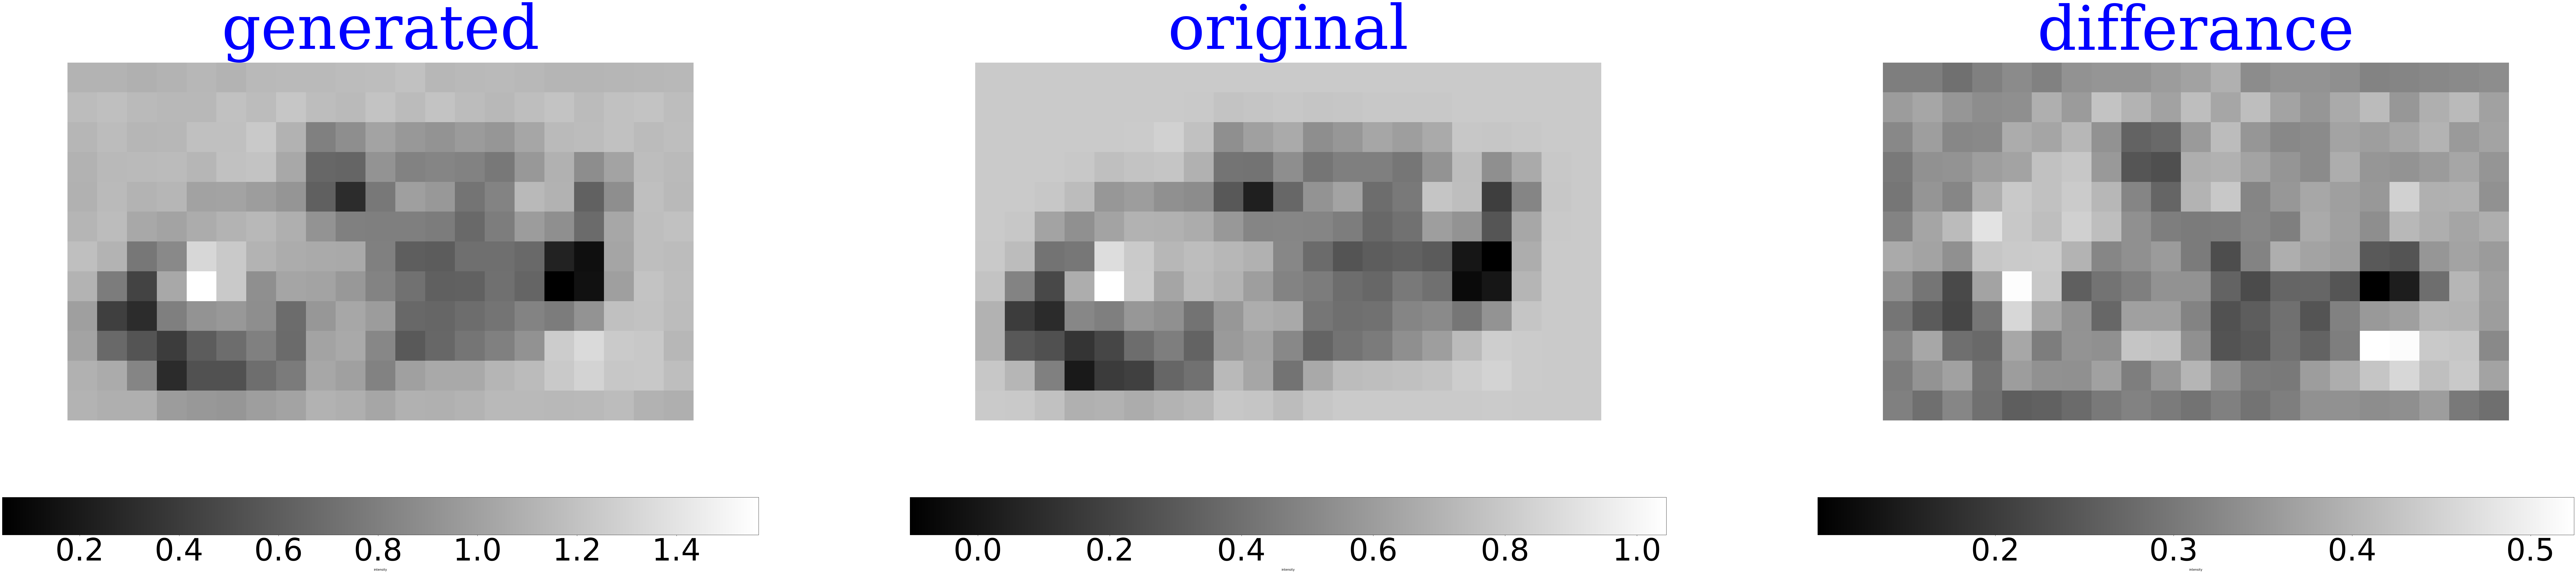

In [43]:
model=torch.load('model.pt').to(device)
model.eval()
img_dir="C:/Users/moham/OneDrive/Bureau/summer_internship/data/grp1/"
x,y=data[0]
print(np.shape(x))
x=x.to(device)
"""
for i in range (10):
    plt.imshow(x[i].detach().cpu(),cmap='gray')
    plt.colorbar(label="intensity", orientation="horizontal") 
    plt.show()
"""
font = {'family':'serif','color':'blue','size':200}
y=y.to(device)
x_t = torch.randn((1, IMG_CH, IMG_height, IMG_width), device=device)
for i in range(0, T)[::-1]:
    t = torch.full((1,), i, device=device)
    e_t = model(x_t, t,y.unsqueeze(0))  # Predicted noise
    x_t = reverse_q(x_t, t, e_t)
    if i == 0:
        
        for j in range (10):
           
            plt.figure(figsize=(150,30))
            plt.axis("off")
            ax = plt.subplot( 1 ,3, 1)
            ax.axis('off')
            generated=x_t[0][j][:,0:21]
            original=x[j][:,0:21]
            differance=generated.squeeze()-original
            plt.imshow((generated).squeeze().detach().cpu(),cmap='gray')
            plt.title('generated',fontdict=font)
            cbar=plt.colorbar(label="intensity", orientation="horizontal")
            cbar.ax.tick_params(labelsize=100)
            ax = plt.subplot( 1,3, 2)
            ax.axis('off')
            plt.imshow((original).detach().cpu(),cmap='gray')
            plt.title('original',fontdict=font)
            cbar=plt.colorbar(label="intensity", orientation="horizontal")
            cbar.ax.tick_params(labelsize=100)
            print(torch.mean(torch.abs(differance[original-torch.median(original)>0.0001]))*(std[j]/10000))#differance between original image
            ax = plt.subplot( 1 ,3, 3)
            ax.axis('off')
            plt.imshow(torch.abs((generated.squeeze()-original)).detach().cpu(),cmap='gray')
            plt.title('differance',fontdict=font)
            cbar=plt.colorbar(label="intensity", orientation="horizontal")
            cbar.ax.tick_params(labelsize=100)
            plt.show()

In [ ]:
model.eval()
figsize=(100,100) # Change me
ncols = 25 # Should evenly divide T
y=(h.to(device)).unsqueeze(0)
sample_images(y,ncols, "eval" , figsize=figsize,)